In [1]:
RAY_SWITCH = True # allow task-based parallel optimization by ray if set to True  

In [2]:
from sympy import init_printing; init_printing()

if RAY_SWITCH: 
    import ray; ray.init()
    def raylize_func(func):
        @ray.remote
        def raylized_func(*args, **kwargs):
            return func(*args, **kwargs)    
        return raylized_func

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # display all expression in one cell instead of the last one

/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)
2021-05-16 15:07:07,971	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


## Initialization of Variables

In [3]:
from sympy import integrate, Eq, symbols, Array, Function
from sinupy.algebra.tensor import cross
x, y, z = symbols('x, y, z', real=True); t = symbols("t", real=True)
E_x, E_y, E_z = symbols("E_x, E_y, E_z", real=True); E = Array([E_x, E_y, E_z]); E # Array([E_x, E_y, E_z]) or Array([E_x, 0, 0])
B_x, B_y, B_z = symbols("B_x, B_y, B_z", positive=True); B = Array([0, 0, B_z]); B # Array([B_x, B_y, B_z]) or Array([0, 0, B_z])
r_x, r_y, r_z = [f(t) for f in symbols("r_x, r_y, r_z", real=True, cls=Function)]; r = Array([r_x, r_y, r_z])
v_x, v_y, v_z = [f(t) for f in symbols("v_x, v_y, v_z", real=True, cls=Function)]; v = Array([v_x, v_y, v_z])
m = symbols('m', positive=True); q = symbols('q', nonzero=True, real=True)


/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: Matpl

[Eₓ  E_y  E_z]

[0  0  B_z]

## Set up the Newton Second Law Equation (ode system)

In [26]:
Newton2 = Eq(q*E + q* cross(v, B), m * v.diff(t) ); 
diff_r_is_v = Eq(r.diff(t), v); diff_r_is_v

/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: Matpl

⎡d          d           d         ⎤                          
⎢──(rₓ(t))  ──(r_y(t))  ──(r_z(t))⎥ = [vₓ(t)  v_y(t)  v_z(t)]
⎣dt         dt          dt        ⎦                          

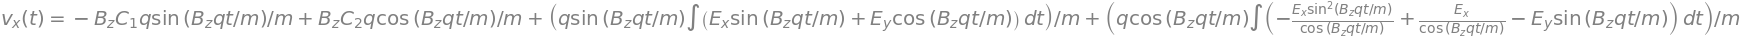

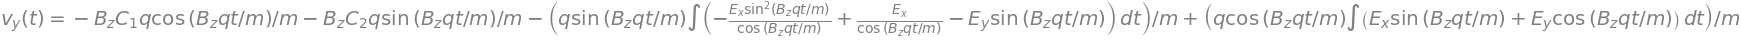

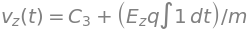

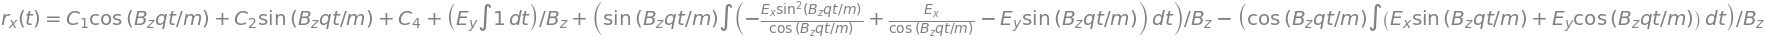

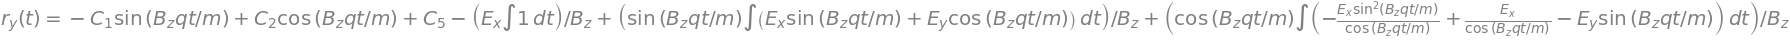

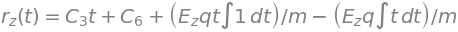

In [27]:
from sympy import simplify, sqrt, trigsimp, refine, Q, sin, cos, pi, Abs
simplify = raylize_func(simplify)
trigsimp = raylize_func(trigsimp)
# [func = raylize_func(func) for func in [simplify,sqrt]]
import sympy.solvers.ode as ode
from wagglepy.symutil import divide_Array_Eq

# v_sol = ode.systems.dsolve_system(
#     divide_Array_Eq(Newton2))
# for i in range(3): v_sol[0][i]
# for i in range(3): v_sol[0][i].simplify()

v_r_sol = ode.systems.dsolve_system(
    [*divide_Array_Eq(Newton2),
     *divide_Array_Eq(diff_r_is_v)])
for comp_sol in v_r_sol[0]: comp_sol

v_r_sol[0] = ray.get([simplify.remote(comp_sol) for comp_sol in v_r_sol[0]]) if RAY_SWITCH \
    else [simplify(comp_sol) for comp_sol in v_r_sol[0]]
    
for comp_sol in v_r_sol[0]: comp_sol

### Time Averaging

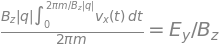

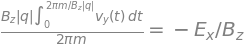

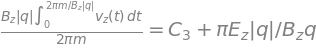

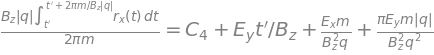

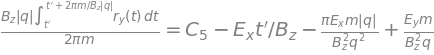

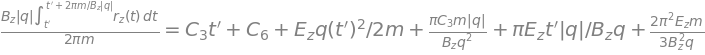

In [28]:
from wagglepy.symutil.characteristics import min_period
from wagglepy.symutil.op import time_average_of_TrigFunc
tprime = symbols('t^{\prime}', real=True)
T = min_period(v_r_sol[0][0].rhs, t)


def subs_multiple_pi_trig_func(expr):
    return expr\
            .subs(sin((2*pi*q)/Abs(q)), 0)\
            .subs(sin((pi*q)/Abs(q)), 0)\
            .subs(cos((2*pi*q)/Abs(q)), 1)
def t_avg_Eq(eq, Tmin, Tmax):
        return Eq(
            time_average_of_TrigFunc(eq.lhs, t, T=[Tmin, Tmax]),
            time_average_of_TrigFunc(eq.rhs, t, T=[Tmin, Tmax]))
def simplify_rhs(eq):
    return Eq(eq.lhs, eq.rhs.simplify())

if RAY_SWITCH: 
    t_avg_Eq = raylize_func(t_avg_Eq)
    subs_multiple_pi_trig_func = raylize_func(subs_multiple_pi_trig_func)
    simplify_rhs = raylize_func(simplify_rhs)
    
    # t_avg_EqSol.remote(v_r_sol[0][0])
    # t_avg_EqSol.remote(v_r_sol[0][1])
    # t_avg_EqSol.remote(v_r_sol[0][2])
    # print("The above formulas might look too cumbersome, let's simplify them.")
    futures = []
    for i, comp_sol in enumerate(v_r_sol[0]):
        t_avg_comp_future = t_avg_Eq.remote(comp_sol, 0, T) if i < 3 \
            else t_avg_Eq.remote(comp_sol, tprime, tprime+T)
        futures.append(
                simplify_rhs.remote(
                    subs_multiple_pi_trig_func.remote(
                        trigsimp.remote(
                                subs_multiple_pi_trig_func.remote(t_avg_comp_future), 
                        method="fu")
                    )
                ))

    t_avg_Eq_list = ray.get(futures)
    for comp_sol in t_avg_Eq_list: comp_sol
else:
    pass


## Visualization of The Electron Trace Interacting with a Static E.M. Field 

In [38]:
from scipy import constants
import numpy as np
from sympy import lambdify, Symbol
v_r_sol_N = [comp_sol.rhs\
             .subs([(E_x, 10.0), (E_y, 10.0), (E_z, 1e6)])\
             .subs([(B_x, 0.0), (B_y, 0.0), (B_z, 5.0)])\
             .subs([('C1', 1e3), ('C2', 0.0), ('C3', 0.0), ('C4', 0.0), ('C5', 0.0), ('C6', 0.0)])\
             .subs(q, constants.e).subs(m, constants.m_e) for comp_sol in v_r_sol[0]]
for i in range(6): v_r_sol_N[i]

In [43]:
t1 = 2e-5
dt = 3e-9
num_of_t = int(t1 / dt); num_of_t
t_arr = np.arange(num_of_t) * dt

x_arr, y_arr, z_arr = (lambdify(t, v_r_sol_N[i], 'numpy')(t_arr) for i in [3, 4, 5])
# x_rest_arr = x_arr - a_0**2 / 4 * (t_arr-x_arr)
# z_arr = np.zeros_like(x_arr)

vx_arr, vy_arr, vz_arr = (lambdify(t, v_r_sol_N[i], 'numpy')(t_arr) for i in [0, 1, 2])
v_arr = np.sqrt(vx_arr**2 + vy_arr**2 + vz_arr**2)


In [44]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=x_arr, y=y_arr, z=z_arr,
    marker=dict(
        size=2,
        color=v_arr,
        colorscale='Viridis',
    ),
    line=dict(
        width=2,
        color=v_arr,
        colorscale='Viridis',
    )
))

fig.update_layout(
    scene=dict(
        aspectratio = dict( x=1, y=1, z=1.0 ),
        aspectmode = 'data'))
# fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=x_rest_arr, y=y_arr, z=z_arr,
    marker=dict(
        size=4,
        color=v_arr,
        colorscale='Viridis',
    ),
    line=dict(
        color=v_arr,
        width=2
    )
))

fig.update_layout(
    scene=dict(
        aspectratio = dict( x=1, y=1, z=1.0 ),
        aspectmode = 'data'))
fig.show()


## Fast Lambdify by Cupy 

In [ ]:
import cupy as cp

## Bugs to be reported to Sympy

In [ ]:
from sympy import sin, sinh, pi, symbols
a = symbols("a", positive=True)
b, t = symbols("b, t", real=True)
sin(a*t).period(t)

In [ ]:
sin(-a*t).period(t) # AttributeError: 'Mul' object has no attribute 'period'
sin((-1)*a*t).period(t) # AttributeError: 'Mul' object has no attribute 'period'

In [ ]:
sin(b*t).period(t)